# Home Credit Default Risk

1. Introdução
2. Descrição dos dados
3. Carregando os dados
4. Análise Exploratória
5. Correlação | Correlation
6. Feature Selection with Random Forest
7. ...

## 1. Introdução 

Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

[Home Credit Group](http://www.homecredit.net/) strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.


## 2. Descrição dos Dados


* application_{train|test}.csv

    * This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
    * Static data for all applications. One row represents one loan in our data sample.

* bureau.csv

    * All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
    * For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

* bureau_balance.csv

    * Monthly balances of previous credits in Credit Bureau.
    * This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

* POS_CASH_balance.csv

Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.
credit_card_balance.csv

Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.
previous_application.csv

All previous applications for Home Credit loans of clients who have loans in our sample.
There is one row for each previous application related to loans in our data sample.
installments_payments.csv

Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
There is a) one row for every payment that was made plus b) one row each for missed payment.
One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.
HomeCredit_columns_description.csv

This file contains descriptions for the columns in the various data files.

![teste](home_credit.png)

** Pacotes **

In [1]:
# Instalação dos pacotes.
# !pip install imblearn
# !pip install lightgbm

import time
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import fbeta_score
from sklearn.metrics import classification_report

# DataViz
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.offline as offline
offline.init_notebook_mode()

# import cufflinks and offline mode
import cufflinks as cf
cf.go_offline()

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
# plt.style.use('fivethirtyeight')
# plt.style.use('ggplot')
plt.style.use('seaborn')
# sns.set_style('whitegrid')

# Memory management
import gc 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


## 3. Carregando os dados

In [2]:
def load_data(data_src):
    
    start_time = time.time()
    
    train = pd.read_csv('{}application_train.csv'.format(data_src))
    test = pd.read_csv('{}application_test.csv'.format(data_src))
    print('Train and test tables loaded.')
    
    bureau = pd.read_csv('{}bureau.csv'.format(data_src))
    bureau_bal = pd.read_csv('{}bureau_balance.csv'.format(data_src))
    print('Bureau data loaded.')
    
    prev = pd.read_csv('{}previous_application.csv'.format(data_src))
    print('Previous applications data loaded.')
    
    cred_card_bal = pd.read_csv('{}credit_card_balance.csv'.format(data_src))
    print('Credit card balance loaded.')
    
    pos_cash_bal = pd.read_csv('{}POS_CASH_balance.csv'.format(data_src))
    print('POS cash balance loaded.')
    
    ins = pd.read_csv('{}installments_payments.csv'.format(data_src))
    print('Installments data loaded.')
    
    # error if using engine c - 'utf-8' codec can't decode byte 0x85
    data_description = pd.read_csv('{}HomeCredit_columns_description.csv'.format(data_src), engine='python')
    
    print('Time it took to load all the data: {:.4f}s\n'.format(time.time() - start_time))
    
    return train, test, bureau, bureau_bal, prev, cred_card_bal, pos_cash_bal, ins, data_description

train, test, bureau, bureau_bal, prev, cred_card_bal, pos_cash_bal, ins, data_description = load_data('data/all/')

# Copia 
df_train = train.copy()
df_test = test.copy()

Train and test tables loaded.
Bureau data loaded.
Previous applications data loaded.
Credit card balance loaded.
POS cash balance loaded.
Installments data loaded.
Time it took to load all the data: 69.5470s



In [3]:
# Copia 
df_train = train.copy()
df_test = test.copy()

## Análise Exploratória

Distribuição da variável - Good(0) e Bad(1): 
0    282686
1     24825
Name: TARGET, dtype: int64


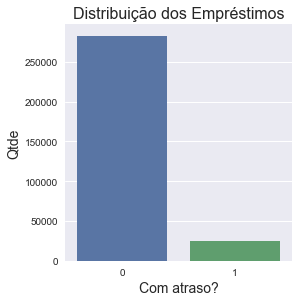

In [176]:
print("Distribuição da variável - Good(0) e Bad(1): ")
print(df_train["TARGET"].value_counts())

sns.factorplot(x ="TARGET", kind='count', data=df_train, size=4)
plt.title("Distribuição dos Empréstimos", fontsize=16)
plt.xlabel("Com atraso?", fontsize=14)
plt.ylabel("Qtde", fontsize=14)
plt.show()

## Missing values

In [3]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [4]:
def drop_missing_col(train, test):
    missing_train = missing_values_table(train)
    missing_test = missing_values_table(test)
    
    missing_train_vars = list(missing_train.index[missing_train['% of Total Values'] > 70])
    missing_test_vars = list(missing_test.index[missing_test['% of Total Values'] > 70])

    missing_columns = list(set(missing_test_vars + missing_train_vars))
    
    # Drop the missing columns
    train = train.drop(missing_columns, axis=1)
    test = test.drop(missing_columns, axis=1)
    
    return train, test

In [5]:
missing_values_table(df_train).head(10)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [6]:
missing_values_table(test).head(10)

Your selected dataframe has 121 columns.
There are 64 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MODE,33495,68.7
COMMONAREA_MEDI,33495,68.7
COMMONAREA_AVG,33495,68.7
NONLIVINGAPARTMENTS_MEDI,33347,68.4
NONLIVINGAPARTMENTS_AVG,33347,68.4
NONLIVINGAPARTMENTS_MODE,33347,68.4
FONDKAPREMONT_MODE,32797,67.3
LIVINGAPARTMENTS_MODE,32780,67.2
LIVINGAPARTMENTS_MEDI,32780,67.2
LIVINGAPARTMENTS_AVG,32780,67.2


## Feature Engineering

** Função para agregar dados numéricos ** 

Isso agrupa os dados pelo group_var e calcula mean, max, min e sum. Só será aplicado a dados numéricos por padrão em pandas.

In [7]:
def agg_numeric(df, parent_var, df_name):

    # Remove id variables other than grouping variable
    for col in df:
        if col != parent_var and 'SK_ID' in col:
            df = df.drop(col, axis=1)
        if col != parent_var and 'index' in col:
            df = df.drop(col, axis=1)

    numeric_feats = [f for f in df.drop(parent_var, axis=1).columns if df[f].dtype == 'int64' or df[f].dtype == 'float64']  

    # Only want the numeric variables
    parent_ids = df[parent_var].copy()
    numeric_df = df[numeric_feats].copy()
    numeric_df[parent_var] = parent_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(parent_var).agg(['count', 'mean', 'max', 'min', 'sum'])

    # Need to create new column names
    columns = []

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        if var != parent_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))
    
    agg.columns = columns
    
    # Remove the columns with all redundant values
    _, idx = np.unique(agg, axis = 1, return_index=True)
    agg = agg.iloc[:, idx]
    
    return agg

** Função para calcular contagens categóricas **

Essa função calcula as ocorrências (contagens) de cada categoria em uma variável categórica para cada cliente. Ele também calcula a contagem normalizada, que é a contagem de uma categoria dividida pelo total de contagens de todas as categorias em uma variável categórica.

In [8]:
def agg_categorical(df, parent_var, df_name):
    
    categorical_feats = [f for f in df.columns if df[f].dtype == 'object']
    
    # Select the categorical columns
    categorical = pd.get_dummies(df[categorical_feats])

    # Make sure to put the identifying id on the column
    categorical[parent_var] = df[parent_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(parent_var).agg(['sum', 'count', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['sum', 'count', 'mean']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    # Remove duplicate columns by values
    _, idx = np.unique(categorical, axis = 1, return_index = True)
    categorical = categorical.iloc[:, idx]
    
    return categorical

** Função para Agregar Estatísticas no Nível do Cliente **

In [9]:
def aggregate_client(df, group_vars, df_names):
    
    # Aggregate the numeric columns
    df_agg = agg_numeric(df, parent_var = group_vars[0], df_name = df_names[0])
    
    # If there are categorical variables
    if any(df.dtypes == 'object'):
        
        # Count the categorical columns
        df_counts = agg_categorical(df, parent_var = group_vars[0], df_name = df_names[0])

        # Merge the numeric and categorical
        df_by_loan = df_counts.reset_index().merge(df_agg.reset_index(), on = group_vars[0], how = 'outer')

        gc.enable()
        del df_agg, df_counts
        gc.collect()

        # Merge to get the client id in dataframe
        df_by_loan = df_by_loan.reset_index().merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')

        # Remove the loan id
        df_by_loan = df_by_loan.drop([group_vars[0]], axis=1)

        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])
        
    # No categorical variables
    else:
        
        # Merge to get the client id in dataframe
        df_by_loan = df_agg.reset_index().merge(df[[group_vars[0], group_vars[1]]].reset_index(), on = group_vars[0], how = 'left')
        
        gc.enable()
        del df_agg
        gc.collect()
        
        # Remove the loan id
        df_by_loan = df_by_loan.drop([group_vars[0]], axis=1)
 
        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])
        
    # Memory management
    gc.enable()
    del df, df_by_loan
    gc.collect()

    return df_by_client

** Gráficos de Estimativa de Densidade de Kernel ** 

O gráfico de estimativa de densidade do núcleo mostra a distribuição de uma única variável (pense nisso como um histograma suavizado). Para ver as diferentes distribuições dependentes do valor de uma variável categórica, podemos colorir as distribuições de maneira diferente de acordo com a categoria. Por exemplo, podemos mostrar a estimativa da densidade do kernel do previous_loan_count colorido por se o TARGET = 1 ou 0. O KDE resultante mostrará quaisquer diferenças significativas na distribuição da variável entre pessoas que não pagaram seu empréstimo (TARGET == 1 ) e as pessoas que fizeram (TARGET == 0). Isso pode servir como um indicador de se uma variável será "relevante" para um modelo de aprendizado de máquina.

In [10]:
# Plots the disribution of a variable colored by value of the target
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.ix[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.ix[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.ix[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.ix[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)

In [11]:
def join_tables(train, test):

    bureau_agg = agg_numeric(bureau.drop(['SK_ID_BUREAU'], axis=1), parent_var='SK_ID_CURR', df_name='bureau')
    bureau_counts = agg_categorical(bureau, parent_var='SK_ID_CURR', df_name='bureau')

    # Counts of each type of status for each previous loan
    bureau_balance_counts = agg_categorical(bureau_bal, parent_var='SK_ID_BUREAU', df_name='bureau_balance')
    # Calculate value count statistics for each `SK_ID_CURR` 
    bureau_balance_agg = agg_numeric(bureau_bal, parent_var='SK_ID_BUREAU', df_name='bureau_balance_')
    
    # Dataframe grouped by the loan
    bureau_by_loan = bureau_balance_agg.reset_index().merge(bureau_balance_counts.reset_index(), right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')
    # Merge to include the SK_ID_CURR
    bureau_by_loan = bureau_by_loan.merge(bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], on = 'SK_ID_BUREAU', how = 'left')
    bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(['SK_ID_BUREAU'], axis=1), parent_var='SK_ID_CURR', df_name='client')

    previous_agg = agg_numeric(prev, 'SK_ID_CURR', 'previous')
    previous_counts = agg_categorical(prev, 'SK_ID_CURR', 'previous')
    
    print('Finished group by ...')

    # Merge with the value counts of bureau
    train = train.merge(bureau_counts.reset_index(), on = 'SK_ID_CURR', how = 'left')
    # Merge with the stats of bureau
    train = train.merge(bureau_agg.reset_index(), on = 'SK_ID_CURR', how = 'left')
    # Merge with the monthly information grouped by client
    train = train.merge(bureau_balance_by_client.reset_index(), on = 'SK_ID_CURR', how = 'left')
    # Merge in the previous information
    train = train.merge(previous_counts.reset_index(), on ='SK_ID_CURR', how = 'left')
    train = train.merge(previous_agg.reset_index(), on = 'SK_ID_CURR', how = 'left')
    
    # Merge with the value counts of bureau
    test = test.merge(bureau_counts.reset_index(), on = 'SK_ID_CURR', how = 'left')
    # Merge with the stats of bureau
    test = test.merge(bureau_agg.reset_index(), on = 'SK_ID_CURR', how = 'left')
    # Merge with the value counts of bureau balance
    test = test.merge(bureau_balance_by_client.reset_index(), on = 'SK_ID_CURR', how = 'left')
    # Merge in the previous information
    test = test.merge(previous_counts.reset_index(), on ='SK_ID_CURR', how = 'left')
    test = test.merge(previous_agg.reset_index(), on='SK_ID_CURR', how = 'left')
    
    return train, test

df_train, df_test = join_tables(df_train, df_test)

df_train, df_test = drop_missing_col(df_train, df_test)

print('train shape: {}'.format(df_train.shape))
print('test shape: {}'.format(df_test.shape))

Finished group by ...
Your selected dataframe has 684 columns.
There are 629 columns that have missing values.
Your selected dataframe has 683 columns.
There are 626 columns that have missing values.
train shape: (307511, 604)
test shape: (48744, 603)


In [12]:

def join_agg_client(train, test):

    cash_by_client = aggregate_client(pos_cash_bal, 
                                      group_vars=['SK_ID_PREV', 'SK_ID_CURR'], 
                                      df_names=['cash', 'client'])
    
    credit_by_client = aggregate_client(cred_card_bal, 
                                        group_vars=['SK_ID_PREV', 'SK_ID_CURR'], 
                                        df_names=['credit', 'client'])
    
    installments_by_client = aggregate_client(ins, 
                                              group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], 
                                              df_names = ['installments', 'client'])

    train = train.merge(cash_by_client.reset_index(), on = 'SK_ID_CURR', how = 'left')
    train = train.merge(credit_by_client.reset_index(), on='SK_ID_CURR', how='left')
    train = train.merge(installments_by_client.reset_index(), on = 'SK_ID_CURR', how = 'left')
    
    test = test.merge(cash_by_client.reset_index(), on='SK_ID_CURR', how = 'left')
    test = test.merge(credit_by_client.reset_index(), on='SK_ID_CURR', how = 'left')
    test = test.merge(installments_by_client.reset_index(), on = 'SK_ID_CURR', how = 'left')
    
    return train, test

df_train, df_test = join_agg_client(df_train, df_test)

df_train, df_test = drop_missing_col(df_train, df_test)

print('train shape: {}'.format(df_train.shape))
print('test shape: {}'.format(df_test.shape))

Your selected dataframe has 1197 columns.
There are 1142 columns that have missing values.
Your selected dataframe has 1196 columns.
There are 1139 columns that have missing values.
train shape: (307511, 840)
test shape: (48744, 839)


## Correlations

In [13]:
# Calculate all correlations in dataframe
corrs = abs(df_train.corr())

corrs = corrs.sort_values('TARGET', ascending = False)

# Ten most positive correlations
pd.DataFrame(corrs['TARGET'].head(15))

,TARGET
TARGET,1.000000
EXT_SOURCE_3,0.178919
EXT_SOURCE_2,0.160472
EXT_SOURCE_1,0.155317
bureau_DAYS_CREDIT_mean,0.089729
client_bureau_balance__MONTHS_BALANCE_min_mean,0.089038
client_bureau_balance__MONTHS_BALANCE_count_mean,0.080193
bureau_CREDIT_ACTIVE_Closed_mean,0.079369
DAYS_BIRTH,0.078239
previous_NAME_CONTRACT_STATUS_Refused_mean,0.077671


In [80]:
def feature_select(df, corr): 
    feature_importances = pd.DataFrame(corr['TARGET'].copy()).reset_index()
    feature_importances.rename(columns={'index': 'feature', 'TARGET': 'importance'}, inplace=True)
    # print(feature_importances.drop(0).head())
    return df[feature_importances['feature'].drop(0).head(70).values]

df_train = feature_select(df_train, corrs)
df_test = feature_select(df_test, corrs)

df_train['TARGET'] = train['TARGET']



** Variáveis colineares ** 

Podemos calcular não apenas as correlações das variáveis com o alvo, mas também a correlação de cada variável com todas as outras variáveis. Isso nos permitirá ver se há variáveis altamente colineares que talvez devam ser removidas dos dados.

Vamos procurar quaisquer variáveis que tenham uma correlação maior que 0.8 com outras variáveis.

In [75]:
# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])
    
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

train_corrs_removed = df_train.drop(cols_to_remove, axis=1)
test_corrs_removed = df_test.drop(cols_to_remove, axis=1)

print('Training Corrs Removed Shape: ', train_corrs_removed.shape)
print('Testing Corrs Removed Shape: ', test_corrs_removed.shape)

Number of columns to remove:  367


ValueError: labels ['previous_AMT_DOWN_PAYMENT_mean' 'bureau_CREDIT_TYPE_Consumer credit_sum'
 'previous_NAME_SELLER_INDUSTRY_Furniture_mean'
 'client_installments_NUM_INSTALMENT_NUMBER_max_sum' 'NONLIVINGAREA_MODE'
 'YEARS_BUILD_MEDI' 'bureau_AMT_CREDIT_SUM_DEBT_count'
 'client_installments_AMT_PAYMENT_max_mean'
 'client_installments_DAYS_ENTRY_PAYMENT_max_mean'
 'bureau_AMT_CREDIT_MAX_OVERDUE_mean' 'client_cash_SK_DPD_DEF_sum_min'
 'client_cash_NAME_CONTRACT_STATUS_Active_mean_max'
 'client_cash_NAME_CONTRACT_STATUS_XNA_mean_sum'
 'client_installments_NUM_INSTALMENT_VERSION_count_min'
 'previous_NAME_GOODS_CATEGORY_XNA_sum' 'bureau_AMT_CREDIT_SUM_OVERDUE_sum'
 'NONLIVINGAPARTMENTS_MODE'
 'previous_NAME_CONTRACT_TYPE_Consumer loans_sum'
 'client_installments_DAYS_INSTALMENT_sum_min'
 'previous_AMT_APPLICATION_count'
 'client_cash_CNT_INSTALMENT_FUTURE_max_max'
 'client_installments_DAYS_INSTALMENT_min_sum' 'previous_AMT_ANNUITY_count'
 'previous_NAME_SELLER_INDUSTRY_XNA_sum'
 'client_cash_CNT_INSTALMENT_count_sum' 'ENTRANCES_MODE'
 'client_installments_DAYS_ENTRY_PAYMENT_sum_min'
 'previous_NAME_CASH_LOAN_PURPOSE_Hobby_sum'
 'client_cash_MONTHS_BALANCE_mean_max'
 'client_installments_AMT_INSTALMENT_sum_mean' 'client_cash_SK_DPD_max_sum'
 'FLOORSMIN_MEDI' 'client_cash_CNT_INSTALMENT_sum_max'
 'client_cash_SK_DPD_sum_mean'
 'client_cash_NAME_CONTRACT_STATUS_Active_count_max'
 'client_installments_NUM_INSTALMENT_VERSION_mean_sum'
 'previous_CODE_REJECT_REASON_SYSTEM_sum'
 'client_installments_NUM_INSTALMENT_NUMBER_sum_mean'
 'previous_NAME_CASH_LOAN_PURPOSE_XAP_sum' 'bureau_CNT_CREDIT_PROLONG_sum'
 'previous_NAME_CONTRACT_TYPE_Cash loans_count' 'bureau_AMT_CREDIT_SUM_max'
 'client_cash_NAME_CONTRACT_STATUS_Returned to the store_mean_mean'
 'previous_FLAG_LAST_APPL_PER_CONTRACT_N_sum'
 'previous_NAME_PORTFOLIO_Cars_mean'
 'previous_FLAG_LAST_APPL_PER_CONTRACT_Y_sum'
 'client_installments_AMT_INSTALMENT_min_min'
 'client_cash_CNT_INSTALMENT_FUTURE_count_max'
 'previous_NAME_CONTRACT_STATUS_Canceled_sum'
 'YEARS_BEGINEXPLUATATION_MEDI'
 'client_installments_DAYS_INSTALMENT_max_max'
 'client_bureau_balance__MONTHS_BALANCE_mean_sum'
 'client_installments_DAYS_ENTRY_PAYMENT_mean_sum'
 'client_cash_CNT_INSTALMENT_min_max'
 'client_cash_CNT_INSTALMENT_FUTURE_max_mean'
 'previous_NAME_CLIENT_TYPE_New_mean' 'client_cash_SK_DPD_DEF_min_sum'
 'client_cash_NAME_CONTRACT_STATUS_Active_count_min'
 'client_cash_MONTHS_BALANCE_max_max' 'bureau_CREDIT_DAY_OVERDUE_sum'
 'previous_CODE_REJECT_REASON_XAP_sum'
 'previous_NAME_CONTRACT_STATUS_Canceled_mean' 'LANDAREA_MODE'
 'client_installments_AMT_PAYMENT_mean_sum'
 'client_installments_NUM_INSTALMENT_NUMBER_mean_min'
 'client_cash_SK_DPD_DEF_max_mean' 'bureau_AMT_CREDIT_MAX_OVERDUE_sum'
 'client_installments_NUM_INSTALMENT_NUMBER_max_max'
 'bureau_DAYS_CREDIT_ENDDATE_count' 'previous_NAME_PORTFOLIO_XNA_sum'
 'client_installments_NUM_INSTALMENT_NUMBER_mean_max'
 'previous_NAME_GOODS_CATEGORY_Mobile_sum'
 'client_cash_NAME_CONTRACT_STATUS_Active_count_sum' 'COMMONAREA_MEDI'
 'client_installments_DAYS_INSTALMENT_sum_count' 'APARTMENTS_MODE'
 'client_cash_SK_DPD_min_sum' 'client_cash_MONTHS_BALANCE_min_sum'
 'previous_DAYS_LAST_DUE_max' 'LIVINGAPARTMENTS_MEDI'
 'client_installments_NUM_INSTALMENT_VERSION_mean_min'
 'client_cash_NAME_CONTRACT_STATUS_Active_mean_mean'
 'client_installments_NUM_INSTALMENT_NUMBER_max_mean'
 'previous_NAME_GOODS_CATEGORY_Clothing and Accessories_sum'
 'client_cash_CNT_INSTALMENT_FUTURE_sum_mean'
 'bureau_AMT_CREDIT_SUM_LIMIT_count' 'client_cash_SK_DPD_mean_max'
 'previous_AMT_DOWN_PAYMENT_max'
 'previous_NAME_SELLER_INDUSTRY_Furniture_sum'
 'client_cash_CNT_INSTALMENT_FUTURE_count_sum'
 'client_cash_SK_DPD_DEF_min_max' 'client_cash_CNT_INSTALMENT_sum_sum'
 'bureau_CREDIT_TYPE_Interbank credit_sum'
 'previous_HOUR_APPR_PROCESS_START_max' 'bureau_AMT_CREDIT_SUM_LIMIT_sum'
 'previous_HOUR_APPR_PROCESS_START_mean'
 'client_cash_CNT_INSTALMENT_mean_min' 'LIVE_REGION_NOT_WORK_REGION'
 'previous_AMT_GOODS_PRICE_max' 'previous_NAME_CONTRACT_TYPE_XNA_sum'
 'client_cash_NAME_CONTRACT_STATUS_Canceled_mean_mean'
 'client_installments_NUM_INSTALMENT_NUMBER_min_sum'
 'previous_NAME_SELLER_INDUSTRY_Consumer electronics_sum'
 'client_cash_CNT_INSTALMENT_max_sum' 'client_cash_MONTHS_BALANCE_sum_min'
 'client_cash_MONTHS_BALANCE_max_mean'
 'previous_NAME_CONTRACT_TYPE_Consumer loans_mean'
 'client_installments_AMT_INSTALMENT_mean_max'
 'client_installments_NUM_INSTALMENT_VERSION_count_max'
 'client_cash_CNT_INSTALMENT_max_max'
 'client_installments_AMT_INSTALMENT_min_max'
 'client_installments_NUM_INSTALMENT_NUMBER_min_max'
 'client_cash_SK_DPD_DEF_sum_mean' 'previous_AMT_CREDIT_sum'
 'COMMONAREA_MODE' 'NONLIVINGAREA_MEDI'
 'client_cash_MONTHS_BALANCE_min_mean'
 'client_installments_AMT_PAYMENT_max_max'
 'client_installments_NUM_INSTALMENT_NUMBER_sum_min'
 'client_cash_NAME_CONTRACT_STATUS_Active_mean_sum'
 'client_bureau_balance__MONTHS_BALANCE_sum_max' 'LIVE_CITY_NOT_WORK_CITY'
 'bureau_AMT_CREDIT_SUM_DEBT_sum' 'previous_NAME_CLIENT_TYPE_Repeater_sum'
 'client_cash_SK_DPD_DEF_mean_sum'
 'client_installments_AMT_INSTALMENT_sum_min'
 'previous_DAYS_TERMINATION_max'
 'client_installments_DAYS_ENTRY_PAYMENT_count_min' 'CNT_FAM_MEMBERS'
 'client_bureau_balance__MONTHS_BALANCE_max_sum'
 'client_installments_DAYS_ENTRY_PAYMENT_sum_count' 'TOTALAREA_MODE'
 'previous_AMT_GOODS_PRICE_mean' 'previous_AMT_APPLICATION_min'
 'previous_CNT_PAYMENT_max' 'client_installments_DAYS_INSTALMENT_sum_max'
 'client_installments_AMT_INSTALMENT_sum_max' 'ENTRANCES_MEDI'
 'previous_CHANNEL_TYPE_Car dealer_sum'
 'client_installments_NUM_INSTALMENT_VERSION_max_max'
 'client_cash_SK_DPD_min_max' 'LIVINGAREA_MODE'
 'client_cash_CNT_INSTALMENT_min_min'
 'client_cash_NAME_CONTRACT_STATUS_Demand_mean_max'
 'client_cash_CNT_INSTALMENT_min_sum'
 'client_installments_NUM_INSTALMENT_VERSION_count_mean'
 'client_bureau_balance__MONTHS_BALANCE_max_mean'
 'previous_NAME_CONTRACT_STATUS_Unused offer_sum'
 'client_installments_NUM_INSTALMENT_VERSION_min_mean'
 'previous_NAME_SELLER_INDUSTRY_Connectivity_mean'
 'previous_AMT_DOWN_PAYMENT_count' 'client_cash_CNT_INSTALMENT_max_mean'
 'previous_AMT_CREDIT_count' 'client_cash_CNT_INSTALMENT_FUTURE_sum_max'
 'client_cash_SK_DPD_DEF_sum_sum'
 'client_bureau_balance__MONTHS_BALANCE_sum_count'
 'client_cash_NAME_CONTRACT_STATUS_XNA_mean_max'
 'previous_DAYS_LAST_DUE_1ST_VERSION_mean'
 'client_installments_NUM_INSTALMENT_VERSION_count_sum'
 'client_installments_DAYS_INSTALMENT_sum_mean'
 'client_bureau_balance__MONTHS_BALANCE_max_min'
 'previous_NAME_SELLER_INDUSTRY_Connectivity_sum'
 'previous_NAME_SELLER_INDUSTRY_XNA_mean'
 'client_installments_AMT_INSTALMENT_mean_mean'
 'client_cash_NAME_CONTRACT_STATUS_XNA_mean_count'
 'previous_AMT_GOODS_PRICE_count' 'client_cash_SK_DPD_max_min'
 'previous_RATE_DOWN_PAYMENT_mean' 'bureau_AMT_CREDIT_MAX_OVERDUE_max'
 'DEF_60_CNT_SOCIAL_CIRCLE'
 'bureau_CREDIT_TYPE_Cash loan (non-earmarked)_sum'
 'bureau_CREDIT_ACTIVE_Bad debt_sum' 'previous_NAME_PORTFOLIO_XNA_mean'
 'previous_NAME_PORTFOLIO_Cars_sum'
 'client_installments_AMT_INSTALMENT_mean_sum'
 'bureau_CREDIT_TYPE_Consumer credit_mean' 'previous_AMT_DOWN_PAYMENT_sum'
 'client_cash_CNT_INSTALMENT_mean_max' 'previous_AMT_APPLICATION_max'
 'client_cash_CNT_INSTALMENT_min_mean'
 'client_installments_AMT_INSTALMENT_sum_sum'
 'previous_NAME_CONTRACT_TYPE_Cash loans_mean' 'APARTMENTS_MEDI'
 'client_cash_CNT_INSTALMENT_FUTURE_min_count' 'client_cash_SK_DPD_max_max'
 'previous_DAYS_FIRST_DRAWING_max'
 'client_installments_DAYS_ENTRY_PAYMENT_sum_mean'
 'client_cash_NAME_CONTRACT_STATUS_Active_count_mean'
 'client_installments_AMT_PAYMENT_max_min'
 'client_cash_NAME_CONTRACT_STATUS_Approved_mean_mean'
 'client_installments_NUM_INSTALMENT_NUMBER_mean_sum'
 'previous_DAYS_TERMINATION_min' 'client_cash_SK_DPD_mean_sum'
 'bureau_DAYS_CREDIT_ENDDATE_max' 'previous_SELLERPLACE_AREA_sum'
 'bureau_CREDIT_CURRENCY_currency 1_mean'
 'client_installments_NUM_INSTALMENT_VERSION_max_mean'
 'previous_AMT_ANNUITY_max' 'bureau_AMT_CREDIT_SUM_count'
 'previous_NAME_PAYMENT_TYPE_Cash through the bank_mean'
 'client_installments_DAYS_INSTALMENT_mean_sum'
 'previous_NAME_PRODUCT_TYPE_XNA_sum' 'previous_AMT_CREDIT_max'
 'previous_DAYS_LAST_DUE_1ST_VERSION_max'
 'client_cash_CNT_INSTALMENT_FUTURE_count_mean'
 'client_cash_MONTHS_BALANCE_mean_mean'
 'client_installments_DAYS_ENTRY_PAYMENT_count_sum' 'BASEMENTAREA_MODE'
 'OBS_60_CNT_SOCIAL_CIRCLE' 'LIVINGAREA_MEDI' 'LIVINGAPARTMENTS_AVG'
 'client_installments_NUM_INSTALMENT_VERSION_sum_sum'
 'client_installments_AMT_PAYMENT_sum_max'
 'client_installments_DAYS_ENTRY_PAYMENT_min_sum'
 'client_cash_SK_DPD_DEF_mean_max'
 'client_installments_NUM_INSTALMENT_NUMBER_sum_max'
 'previous_NAME_GOODS_CATEGORY_Animals_sum'
 'client_installments_DAYS_ENTRY_PAYMENT_count_mean'
 'previous_SELLERPLACE_AREA_mean'
 'client_installments_NUM_INSTALMENT_VERSION_min_min' 'ELEVATORS_MODE'
 'client_cash_SK_DPD_DEF_max_min'
 'client_installments_NUM_INSTALMENT_VERSION_max_sum'
 'client_installments_NUM_INSTALMENT_VERSION_sum_max'
 'client_cash_CNT_INSTALMENT_sum_min' 'previous_CODE_REJECT_REASON_XNA_sum'
 'client_cash_CNT_INSTALMENT_count_max' 'previous_DAYS_FIRST_DUE_max'
 'bureau_AMT_CREDIT_SUM_sum' 'previous_AMT_GOODS_PRICE_sum'
 'client_installments_NUM_INSTALMENT_VERSION_max_min'
 'previous_DAYS_TERMINATION_sum' 'client_cash_CNT_INSTALMENT_sum_mean'
 'ELEVATORS_AVG' 'previous_FLAG_LAST_APPL_PER_CONTRACT_Y_mean'
 'client_installments_DAYS_ENTRY_PAYMENT_max_max'
 'previous_NAME_PRODUCT_TYPE_x-sell_sum' 'client_cash_SK_DPD_sum_sum'
 'FLOORSMIN_MODE' 'YEARS_BEGINEXPLUATATION_MODE'
 'previous_NAME_PRODUCT_TYPE_XNA_mean'
 'previous_NAME_CONTRACT_TYPE_Cash loans_sum'
 'client_cash_MONTHS_BALANCE_sum_mean'
 'client_cash_CNT_INSTALMENT_FUTURE_sum_min'
 'client_cash_CNT_INSTALMENT_FUTURE_mean_max'
 'client_cash_CNT_INSTALMENT_max_min' 'ELEVATORS_MEDI'
 'previous_NAME_PORTFOLIO_POS_mean' 'bureau_CREDIT_ACTIVE_Active_count'
 'previous_HOUR_APPR_PROCESS_START_sum'
 'previous_NAME_CASH_LOAN_PURPOSE_XAP_mean'
 'previous_NFLAG_INSURED_ON_APPROVAL_max' 'LIVINGAREA_AVG'
 'previous_NAME_CASH_LOAN_PURPOSE_XNA_sum'
 'client_installments_DAYS_INSTALMENT_min_max'
 'client_installments_AMT_INSTALMENT_mean_min'
 'client_cash_NAME_CONTRACT_STATUS_Amortized debt_mean_max'
 'client_installments_DAYS_INSTALMENT_mean_max'
 'previous_NAME_GOODS_CATEGORY_Clothing and Accessories_mean'
 'bureau_CREDIT_CURRENCY_currency 4_sum' 'client_cash_SK_DPD_sum_max'
 'client_installments_DAYS_ENTRY_PAYMENT_mean_max'
 'client_cash_NAME_CONTRACT_STATUS_Amortized debt_mean_sum'
 'client_installments_AMT_PAYMENT_max_sum'
 'client_cash_CNT_INSTALMENT_FUTURE_count_min'
 'client_installments_DAYS_ENTRY_PAYMENT_min_max'
 'client_cash_SK_DPD_DEF_max_sum' 'client_cash_SK_DPD_max_mean'
 'client_cash_CNT_INSTALMENT_FUTURE_mean_sum'
 'bureau_CREDIT_CURRENCY_currency 1_sum'
 'client_cash_CNT_INSTALMENT_mean_sum' 'NONLIVINGAPARTMENTS_MEDI'
 'client_installments_NUM_INSTALMENT_NUMBER_sum_sum'
 'client_cash_CNT_INSTALMENT_FUTURE_sum_sum'
 'previous_AMT_APPLICATION_mean'
 'client_cash_NAME_CONTRACT_STATUS_Active_mean_min'
 'client_cash_NAME_CONTRACT_STATUS_Completed_mean_mean'
 'client_installments_NUM_INSTALMENT_NUMBER_mean_mean'
 'client_installments_NUM_INSTALMENT_VERSION_min_sum'
 'client_cash_SK_DPD_sum_min' 'LIVINGAPARTMENTS_MODE'
 'previous_PRODUCT_COMBINATION_Card X-Sell_sum'
 'previous_DAYS_FIRST_DUE_mean' 'client_installments_AMT_PAYMENT_mean_max'
 'client_installments_AMT_INSTALMENT_min_mean'
 'client_installments_DAYS_INSTALMENT_max_mean'
 'previous_AMT_APPLICATION_sum'
 'previous_CHANNEL_TYPE_Credit and cash offices_sum'
 'client_cash_NAME_CONTRACT_STATUS_Demand_mean_sum'
 'bureau_DAYS_CREDIT_count' 'previous_DAYS_TERMINATION_mean'
 'YEARS_BUILD_MODE' 'previous_NAME_PAYMENT_TYPE_Cash through the bank_sum'
 'bureau_DAYS_ENDDATE_FACT_count' 'previous_CNT_PAYMENT_count'
 'client_cash_CNT_INSTALMENT_mean_mean' 'previous_DAYS_FIRST_DRAWING_count'
 'client_cash_SK_DPD_DEF_max_max' 'BASEMENTAREA_MEDI'
 'bureau_CREDIT_TYPE_Loan for purchase of shares (margin lending)_sum'
 'client_installments_DAYS_INSTALMENT_sum_sum' 'LANDAREA_MEDI'
 'bureau_CREDIT_TYPE_Mobile operator loan_sum'
 'client_installments_NUM_INSTALMENT_NUMBER_max_min'
 'previous_NAME_GOODS_CATEGORY_XNA_mean'
 'client_cash_CNT_INSTALMENT_count_mean'
 'client_installments_DAYS_ENTRY_PAYMENT_count_max'
 'client_cash_SK_DPD_DEF_sum_max' 'previous_CNT_PAYMENT_sum'
 'client_cash_CNT_INSTALMENT_FUTURE_max_sum'
 'previous_NFLAG_LAST_APPL_IN_DAY_sum'] not contained in axis

In [76]:
train_corrs_removed = df_train
test_corrs_removed = df_test



## Pipeline de ML

In [81]:
def normalize_categoric(train, test): 

    categorical_feats = [f for f in train.columns if train[f].dtype == 'object']
    
    for col in categorical_feats:
        lb = preprocessing.LabelEncoder()
        lb.fit(list(train[col].values.astype('str')) + list(test[col].values.astype('str')))
        train[col] = lb.transform(list(train[col].values.astype('str')))
        test[col] = lb.transform(list(test[col].values.astype('str')))
        
    return train, test
        
train_corrs_removed, test_corrs_removed = normalize_categoric(train_corrs_removed, test_corrs_removed)

In [82]:
from sklearn.utils import resample

def downsampled(train):

    # Separate majority and minority classes
    df_majority = train[train.TARGET==0]
    df_minority = train[train.TARGET==1]

    # Downsample majority class
    df_majority_downsampled = resample(df_majority, 
                                     replace=False,    # sample without replacement
                                     n_samples=50000,     # to match minority class 24825
                                     random_state=7) # reproducible results

    # Combine minority class with downsampled majority class
    return pd.concat([df_majority_downsampled, df_minority])
    

train_downsampled = downsampled(train_corrs_removed)

# Display new class counts
train_downsampled.TARGET.value_counts()

train_downsampled.shape

(74825, 101)

In [84]:
from sklearn import model_selection

#train_downsampled.fillna(-99, inplace = True)
#test_corrs_removed.fillna(-99, inplace=True)

def train_test_split(data):
    X = data.drop(['TARGET'], axis=1) # data.drop(['SK_ID_CURR', 'TARGET'], axis=1)
    Y = data['TARGET']
    
    return model_selection.train_test_split(X, 
                                            Y, 
                                            test_size=0.3, 
                                            random_state=7)

X_train, X_test, y_train, y_test = train_test_split(train_downsampled)

X_train.shape

(52377, 100)

In [85]:
from sklearn.preprocessing import StandardScaler

def standard_scaler(train, test):
    
    scaler = StandardScaler()
    scaler.fit(train.append(test).fillna(-1))
    
    train = scaler.transform(train.fillna(-1))
    test = scaler.transform(test.fillna(-1))
    
    return train, test

X_train, X_test = standard_scaler(X_train, X_test)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def standard_scaler(train, test):
    
    train.fillna(-1, inplace = True)
    test.fillna(-1, inplace=True)
    
    scaler = StandardScaler()
    scaler.fit(train)
    train = scaler.transform(train)
    test = scaler.transform(test)
    
    return train, test


def pca(train, test):
    
    pca = PCA(0.95)
    pca.fit(train)
    train = pca.transform(train)
    test = pca.transform(test)
    
    return train, test   
    
    
X_train, X_test = standard_scaler(X_train, X_test)    
# X_train, X_test = pca(X_train, X_test)

In [86]:
from sklearn.linear_model import LogisticRegression

model_lg = LogisticRegression(solver='lbfgs')

model_lg.fit(X_train, y_train)

pred = model_lg.predict(X_test)

model_lg.score(X_test, y_test)

0.71311475409836067

In [21]:
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

num_folds = 10
num_instances = len(X_train)
seed = 7

modelos = []
#modelos.append(('LR', LogisticRegression()))
#modelos.append(('CART', DecisionTreeClassifier()))
#modelos.append(('NB', GaussianNB()))
modelos.append(('RF', RandomForestClassifier(max_depth=3, max_features=20, n_estimators=5, random_state=seed)))
#modelos.append(('KNN', KNeighborsClassifier()))
modelos.append(('GBC', GradientBoostingClassifier(max_depth=5, learning_rate = 0.01, random_state=seed)))
modelos.append(('XGB', XGBClassifier(n_estimators=5, seed=seed, learning_rate=0.8, max_depth=5)))
#modelos.append(('AdaBoost', AdaBoostClassifier(n_estimators=5)))



# RESULTADO: SVC: 0.497784 (0.010603)
# modelos.append(('SVC', SVC())) 

# Avaliando cada modelo
resultados = []
nomes = []

for nome, modelo in modelos:
    kfold = cross_validation.KFold(n = num_instances, n_folds = num_folds, random_state = seed)
    cv_results = cross_validation.cross_val_score(modelo, X_train, y_train, cv = kfold, scoring = 'roc_auc')
    resultados.append(cv_results)
    nomes.append(nome)
    msg = "%s: %f (%f)" % (nome, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot para comparar os algoritmos
fig = plt.figure()
fig.suptitle('Comparação de Algoritmos de Classificação')
ax = fig.add_subplot(111)
plt.boxplot(resultados)
ax.set_xticklabels(nomes)
plt.show()


RF: 0.680137 (0.009961)


KeyboardInterrupt: 

(52377, 100)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] n_estimators=250 ................................................
[CV] n_estimators=250 ................................................
[CV] n_estimators=250 ................................................
[CV] n_estimators=250 ................................................
[CV] n_estimators=250 ................................................
[CV] ....... n_estimators=250, score=0.7420351664452298, total=   8.6s
[CV] ....... n_estimators=250, score=0.7520326047142414, total=   8.6s
[CV] ....... n_estimators=250, score=0.7381263112255347, total=   8.7s
[CV] ....... n_estimators=250, score=0.7369495511323126, total=   8.6s
[CV] ....... n_estimators=250, score=0.7426143000054714, total=   8.7s


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.6s remaining:   14.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.8s finished


Predict ...
Best params: {'n_estimators': 250} - Best score: 0.742351586704558
Accuracy: 0.7179704205274412


fbeta: 0.36522494979468273


             precision    recall  f1-score   support

          0       0.73      0.91      0.81     15062
          1       0.64      0.33      0.43      7386

avg / total       0.70      0.72      0.69     22448


 Confusion Matrix:
[[13680  1382]
 [ 4949  2437]]


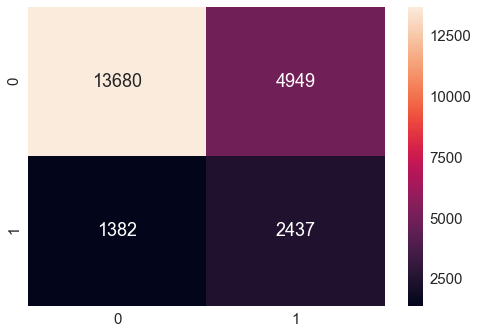

In [87]:
## MELHOR MODELO ATE ENTAO - 24/09

# COm as novas features deu overfitting. Pensar em como resolver 

## Confusion matrix 
# [[13320  1742]
# [ 4138  3248]]

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

print(X_train.shape)

# param_test1 = {'n_estimators':range(20,250,10)}
param_test1 = {'n_estimators': [250]}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, 
                                                               min_samples_split=5,
                                                               min_samples_leaf=50,
                                                               max_leaf_nodes=4, 
                                                               max_depth=5,
                                                               max_features=2,
                                                               random_state=10),
                        param_grid = param_test1, 
                        scoring='roc_auc',
                        n_jobs=-1,
                        iid=False, 
                        cv=5, 
                       verbose=4)

gsearch1.fit(X_train,y_train)


print('Predict ...')
y_pred = gsearch1.predict(X_test)

print('Best params: {0} - Best score: {1}'.format(gsearch1.best_params_, gsearch1.best_score_))

# Verificaar os resultados obtidos
print('Accuracy: {}'.format(accuracy_score(y_test,y_pred)))
print("\n")
print('fbeta: {}'.format(fbeta_score(y_test, y_pred, beta=2)))
print("\n")
print(classification_report(y_test, y_pred))

print("\n Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

#Plot the confusion matrix
sns.set(font_scale=1.5)
cm = confusion_matrix(y_pred, y_test)
sns.heatmap(cm, annot=True, fmt='g')
plt.show()



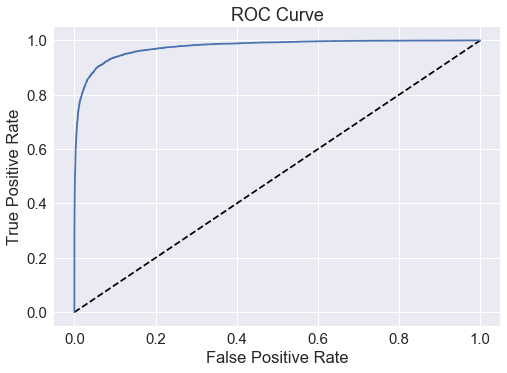

In [51]:
from sklearn.metrics import roc_curve

#Predicting proba
y_pred_prob = gsearch1.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [78]:
print(train_downsampled.shape)
print(test_corrs_removed.drop('SK_ID_CURR', axis=1).fillna(-1).shape)


pd.DataFrame(X_train).head()


(74825, 473)
(48744, 471)


,0,1,2,3,4,5,6,7,8,9,...,462,463,464,465,466,467,468,469,470,471
0,-1.936301,-1.511706,-0.382423,3.073928,3.135057,-0.077587,155685.421237,5.497422e+05,7578.051721,11.537005,...,10994.066732,6127.768348,25301.684448,16108.964075,32875.837953,75462.465823,6.507295e+05,171600.821104,1.058345e+06,3.287445e+06
1,-1.936301,-1.511706,-0.382423,0.376599,3.135057,-0.077587,102752.342475,3.709021e+05,7455.705458,11.537005,...,45021.585068,4274.518735,50205.971217,341434.764974,60013.586767,266259.349270,9.572071e+05,257963.752025,6.156993e+06,3.400693e+07
2,-1.936301,-1.511706,-0.382423,3.073928,3.135057,1.003297,311370.947006,6.731950e+05,7969.559761,11.537005,...,12866.590016,6389.978693,32084.738282,56523.144927,78623.460956,92660.068223,1.242078e+06,327543.051978,1.769094e+06,5.321021e+06
3,-1.936301,-1.511706,-0.382423,3.073928,3.135057,-0.077587,186822.526390,3.531995e+06,36705.360154,2.626189,...,20893.086403,9085.190894,52622.889027,36705.104596,103227.059766,41867.324236,4.975496e+05,131206.353062,9.004728e+05,7.461476e+05
4,-1.936301,-1.511706,-0.382423,0.376599,3.135057,-0.077587,155685.421237,9.572428e+05,8625.780625,11.537005,...,-3.128895,-1.341977,-3.246592,-1.471363,-3.204114,-1.300276,-3.196579e+00,-1.287803,-3.190885e+00,-1.297735e+00


In [69]:
df_resultado = pd.DataFrame()

df_resultado['SK_ID_CURR'] = test['SK_ID_CURR']
x_tmp, test_predict = standard_scaler(train_corrs_removed.drop(['SK_ID_CURR', 'TARGET'], axis=1), 
                                      test_corrs_removed.drop('SK_ID_CURR', axis=1).fillna(-1))

df_resultado['TARGET'] = gsearch1.predict(test_predict)

df_resultado.to_csv('resultado_12_gridsearch1.csv', index=False)

ValueError: Number of features of the model must match the input. Model n_features is 472 and input n_features is 471 

In [65]:
df_resultado = pd.DataFrame()

df_resultado['SK_ID_CURR'] = test['SK_ID_CURR']
test_predict = test_corrs_removed.drop('SK_ID_CURR', axis=1)

df_resultado['TARGET'] = gsearch1.predict(test_predict)

df_resultado.to_csv('resultado_11_gridsearch1.csv', index=False)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] max_depth=3, max_features=4, n_estimators=3 .....................
[CV]  max_depth=3, max_features=4, n_estimators=3, score=0.6378047368555794, total=   1.0s
[CV] max_depth=3, max_features=4, n_estimators=3 .....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV]  max_depth=3, max_features=4, n_estimators=3, score=0.6356610308037896, total=   0.9s
[CV] max_depth=3, max_features=4, n_estimators=3 .....................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s


[CV]  max_depth=3, max_features=4, n_estimators=3, score=0.6470475229817302, total=   0.9s
[CV] max_depth=3, max_features=4, n_estimators=3 .....................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.0s remaining:    0.0s


[CV]  max_depth=3, max_features=4, n_estimators=3, score=0.6420770331336176, total=   1.0s
[CV] max_depth=3, max_features=4, n_estimators=3 .....................
[CV]  max_depth=3, max_features=4, n_estimators=3, score=0.6378493937017451, total=   0.9s
[CV] max_depth=3, max_features=4, n_estimators=5 .....................
[CV]  max_depth=3, max_features=4, n_estimators=5, score=0.6716039545840051, total=   0.9s
[CV] max_depth=3, max_features=4, n_estimators=5 .....................
[CV]  max_depth=3, max_features=4, n_estimators=5, score=0.6561527863296449, total=   0.9s
[CV] max_depth=3, max_features=4, n_estimators=5 .....................
[CV]  max_depth=3, max_features=4, n_estimators=5, score=0.6702718667781729, total=   1.0s
[CV] max_depth=3, max_features=4, n_estimators=5 .....................
[CV]  max_depth=3, max_features=4, n_estimators=5, score=0.6647326194255911, total=   1.0s
[CV] max_depth=3, max_features=4, n_estimators=5 .....................
[CV]  max_depth=3, max_featu

[CV]  max_depth=3, max_features=15, n_estimators=10, score=0.9778087610696073, total=   1.3s
[CV] max_depth=3, max_features=15, n_estimators=25 ...................
[CV]  max_depth=3, max_features=15, n_estimators=25, score=0.9696713041491837, total=   2.0s
[CV] max_depth=3, max_features=15, n_estimators=25 ...................
[CV]  max_depth=3, max_features=15, n_estimators=25, score=0.9875079510484552, total=   2.0s
[CV] max_depth=3, max_features=15, n_estimators=25 ...................
[CV]  max_depth=3, max_features=15, n_estimators=25, score=0.9875966926264159, total=   2.0s
[CV] max_depth=3, max_features=15, n_estimators=25 ...................
[CV]  max_depth=3, max_features=15, n_estimators=25, score=0.9881356086598572, total=   2.1s
[CV] max_depth=3, max_features=15, n_estimators=25 ...................
[CV]  max_depth=3, max_features=15, n_estimators=25, score=0.9712307698811703, total=   2.1s
[CV] max_depth=3, max_features=20, n_estimators=3 ....................
[CV]  max_depth=

[CV]  max_depth=5, max_features=4, n_estimators=5, score=0.6662018571811179, total=   1.0s
[CV] max_depth=5, max_features=4, n_estimators=5 .....................
[CV]  max_depth=5, max_features=4, n_estimators=5, score=0.7222133659430424, total=   1.0s
[CV] max_depth=5, max_features=4, n_estimators=5 .....................
[CV]  max_depth=5, max_features=4, n_estimators=5, score=0.7243110428072226, total=   0.9s
[CV] max_depth=5, max_features=4, n_estimators=10 ....................
[CV]  max_depth=5, max_features=4, n_estimators=10, score=0.9456781128395729, total=   1.1s
[CV] max_depth=5, max_features=4, n_estimators=10 ....................
[CV]  max_depth=5, max_features=4, n_estimators=10, score=0.8920500962003014, total=   1.1s
[CV] max_depth=5, max_features=4, n_estimators=10 ....................
[CV]  max_depth=5, max_features=4, n_estimators=10, score=0.8223207141141038, total=   1.2s
[CV] max_depth=5, max_features=4, n_estimators=10 ....................
[CV]  max_depth=5, max_fe

[CV]  max_depth=5, max_features=15, n_estimators=25, score=0.971736747669, total=   2.8s
[CV] max_depth=5, max_features=15, n_estimators=25 ...................
[CV]  max_depth=5, max_features=15, n_estimators=25, score=0.9882073180357196, total=   2.7s
[CV] max_depth=5, max_features=20, n_estimators=3 ....................
[CV]  max_depth=5, max_features=20, n_estimators=3, score=0.9999987281604638, total=   1.1s
[CV] max_depth=5, max_features=20, n_estimators=3 ....................
[CV]  max_depth=5, max_features=20, n_estimators=3, score=0.9999224177882924, total=   1.1s
[CV] max_depth=5, max_features=20, n_estimators=3 ....................
[CV]  max_depth=5, max_features=20, n_estimators=3, score=0.9999933125856646, total=   1.2s
[CV] max_depth=5, max_features=20, n_estimators=3 ....................
[CV]  max_depth=5, max_features=20, n_estimators=3, score=0.9999923268376526, total=   1.2s
[CV] max_depth=5, max_features=20, n_estimators=3 ....................
[CV]  max_depth=5, max_f

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  5.3min finished


1.0
{'max_depth': 3, 'max_features': 20, 'n_estimators': 3}
Predict ...
Accuracy: 0.9868585174625801


fbeta: 0.9677903644056232


             precision    recall  f1-score   support

          0       0.98      1.00      0.99     15062
          1       1.00      0.96      0.98      7386

avg / total       0.99      0.99      0.99     22448


 Confusion Matrix:
[[15062     0]
 [  295  7091]]


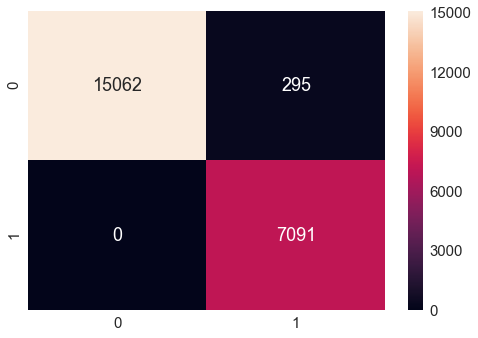

In [32]:
from sklearn.model_selection import GridSearchCV

param_grid = {"max_depth": [3,5],
              "n_estimators":[3,5,10,25],
              "max_features": [4,7,15,20, 25]}

#Creating the classifier
model = RandomForestClassifier(random_state=2)

grid_search2 = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=4)
grid_search2.fit(X_train, y_train)

print(grid_search2.best_score_)
print(grid_search2.best_params_)

print('Predict ...')
y_pred = grid_search2.predict(X_test)

# Verificaar os resultados obtidos
print('Accuracy: {}'.format(accuracy_score(y_test,y_pred)))
print("\n")
print('fbeta: {}'.format(fbeta_score(y_test, y_pred, beta=2)))
print("\n")
print(classification_report(y_test, y_pred))

print("\n Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

#Plot the confusion matrix
sns.set(font_scale=1.5)
cm = confusion_matrix(y_pred, y_test)
sns.heatmap(cm, annot=True, fmt='g')
plt.show()

0.680947744239
{'max_depth': 5, 'max_features': 25, 'n_estimators': 5}
Predict ...
Accuracy: 0.6850944404846757


fbeta: 0.10677671874488226


             precision    recall  f1-score   support

          0       0.69      0.98      0.81     15062
          1       0.66      0.09      0.16      7386

avg / total       0.68      0.69      0.59     22448


 Confusion Matrix:
[[14727   335]
 [ 6734   652]]


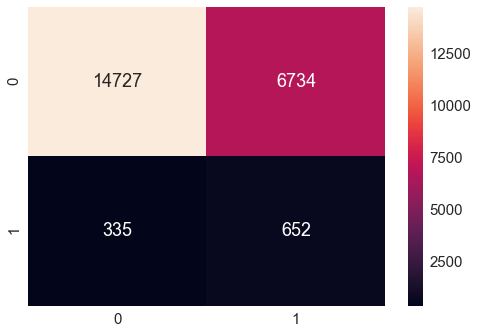

In [143]:
print(grid_search2.best_score_)
print(grid_search2.best_params_)

print('Predict ...')
y_pred = grid_search2.predict(X_test)

# Verificaar os resultados obtidos
print('Accuracy: {}'.format(accuracy_score(y_test,y_pred)))
print("\n")
print('fbeta: {}'.format(fbeta_score(y_test, y_pred, beta=2)))
print("\n")
print(classification_report(y_test, y_pred))

print("\n Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

#Plot the confusion matrix
sns.set(font_scale=1.5)
cm = confusion_matrix(y_pred, y_test)
sns.heatmap(cm, annot=True, fmt='g')
plt.show()

In [34]:
train_downsampled.shape

(74825, 473)

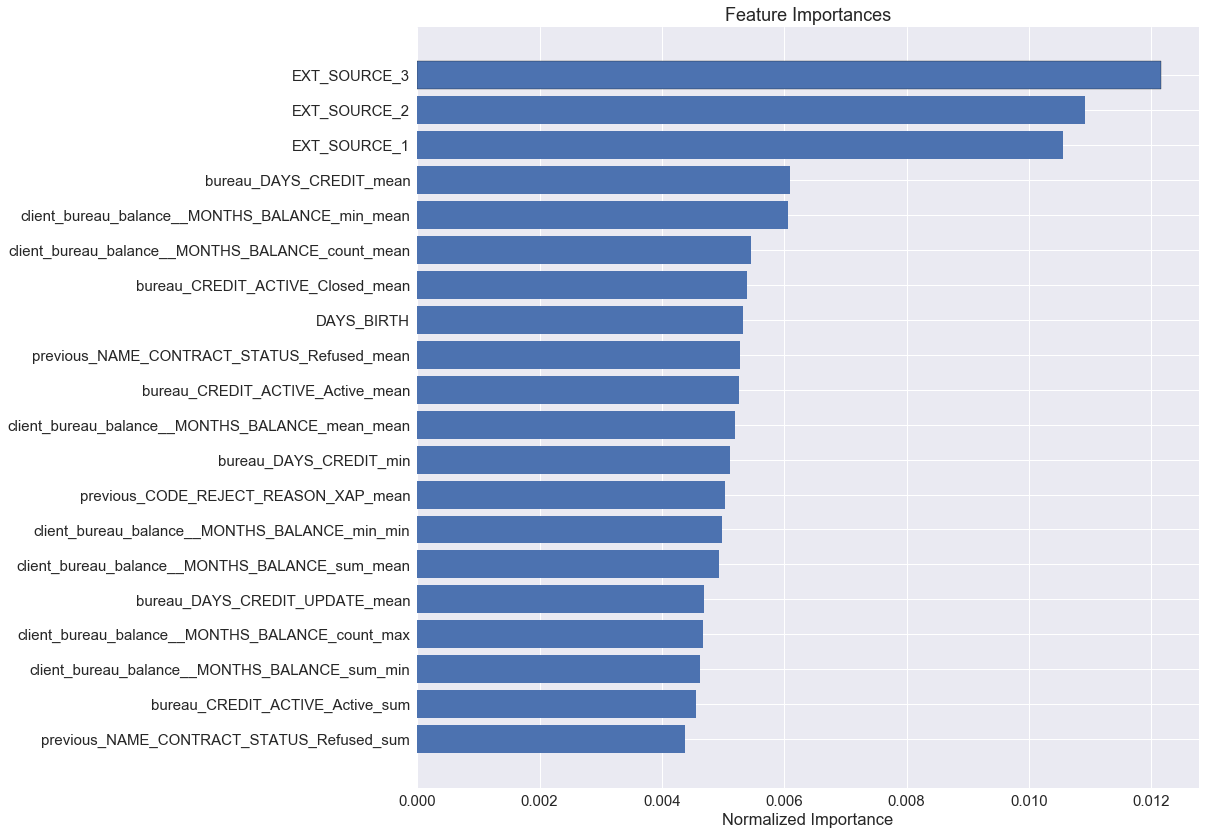

In [33]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22

def plot_feature_importances(df):
    
    df = df[df['feature'] != 'TARGET']
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (14, 14))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:20]))), 
            df['importance_normalized'].head(20), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:20]))))
    ax.set_yticklabels(df['feature'].head(20))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

feature_importances = pd.DataFrame(corrs['TARGET'].copy()).reset_index()
feature_importances.rename(columns={'index': 'feature', 'TARGET': 'importance'}, inplace=True)

aa = plot_feature_importances(feature_importances)


In [209]:
aa.head(30)

,index,feature,importance,importance_normalized
0,1,EXT_SOURCE_3,0.178919,0.012167
1,2,EXT_SOURCE_2,0.160472,0.010913
2,3,EXT_SOURCE_1,0.155317,0.010562
3,4,bureau_DAYS_CREDIT_mean,0.089729,0.006102
4,5,client_bureau_balance__MONTHS_BALANCE_min_mean,0.089038,0.006055
5,6,client_bureau_balance__MONTHS_BALANCE_count_mean,0.080193,0.005454
6,7,bureau_CREDIT_ACTIVE_Closed_mean,0.079369,0.005397
7,8,DAYS_BIRTH,0.078239,0.005321
8,9,previous_NAME_CONTRACT_STATUS_Refused_mean,0.077671,0.005282
9,10,bureau_CREDIT_ACTIVE_Active_mean,0.077356,0.005261


In [205]:
feature_importances

,feature,importance
0,TARGET,1.000000
1,EXT_SOURCE_3,0.178919
2,EXT_SOURCE_2,0.160472
3,EXT_SOURCE_1,0.155317
4,bureau_DAYS_CREDIT_mean,0.089729
5,client_bureau_balance__MONTHS_BALANCE_min_mean,0.089038
6,client_bureau_balance__MONTHS_BALANCE_count_mean,0.080193
7,bureau_CREDIT_ACTIVE_Closed_mean,0.079369
8,DAYS_BIRTH,0.078239
9,previous_NAME_CONTRACT_STATUS_Refused_mean,0.077671


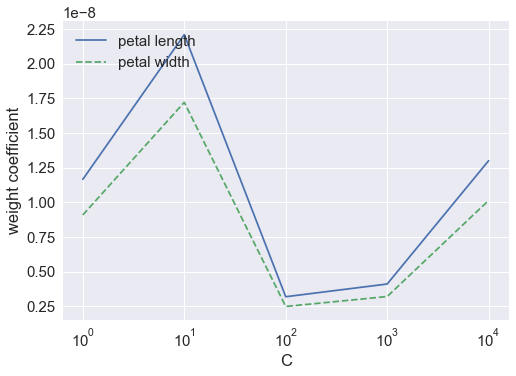

In [46]:
weights, params = [], []

for c in np.arange(0, 5):
    lr = LogisticRegression(C=c, random_state=0)
    lr.fit(X_train, y_train)
    weights.append(lr.coef_[0])
    params.append(10**c)
    
weights = np.array(weights)

plt.plot(params, weights[:, 0], 
         label='petal length')
plt.plot(params, weights[:, 1], linestyle='--', 
         label='petal width')

plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
plt.show()

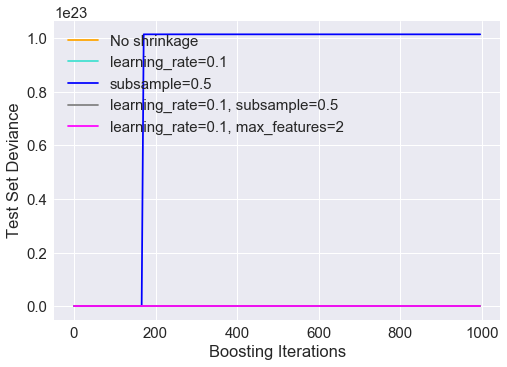

In [90]:
from sklearn import ensemble
from sklearn import datasets

original_params = {'n_estimators': 1000, 'max_leaf_nodes': 4, 'max_depth': 5, 'random_state': 2,
                   'min_samples_split': 5}

plt.figure()

for label, color, setting in [('No shrinkage', 'orange',
                               {'learning_rate': 1.0, 'subsample': 1.0}),
                              ('learning_rate=0.1', 'turquoise',
                               {'learning_rate': 0.1, 'subsample': 1.0}),
                              ('subsample=0.5', 'blue',
                               {'learning_rate': 1.0, 'subsample': 0.5}),
                              ('learning_rate=0.1, subsample=0.5', 'gray',
                               {'learning_rate': 0.1, 'subsample': 0.5}),
                              ('learning_rate=0.1, max_features=2', 'magenta',
                               {'learning_rate': 0.1, 'max_features': 2})]:
    params = dict(original_params)
    params.update(setting)

    clf = ensemble.GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)

    # compute test set deviance
    test_deviance = np.zeros((params['n_estimators'],), dtype=np.float64)

    for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
        # clf.loss_ assumes that y_test[i] in {0, 1}
        test_deviance[i] = clf.loss_(y_test, y_pred)

    plt.plot((np.arange(test_deviance.shape[0]) + 1)[::5], test_deviance[::5],
            '-', color=color, label=label)

plt.legend(loc='upper left')
plt.xlabel('Boosting Iterations')
plt.ylabel('Test Set Deviance')

plt.show()